In [1]:
import PyPDF2 as pypdf
import json
import os
from pdf2image import convert_from_path
import numpy as np
import math
import cv2
from functools import reduce
import sys

import matplotlib.pyplot as plt

In [2]:
def detect(type, pdf_path, basename, id):
    out_file = 'json/%s_%s.json' % (type, id)
    boxes = pypdf.PdfFileReader(pdf_path).getFields()
    data = {}
    if type == 'question':
        data = detect_st(boxes, basename, id)
    elif type == 'solution':
        data = detect_sol(boxes, basename, id)
    os.makedirs(os.path.dirname(out_file), exist_ok=True)
    with open(out_file, 'w') as outfile:
        json.dump(data, outfile, indent=4)

In [3]:
def detect_st(boxes, exam, variant):
    data = {'exam': exam,
            'variant': variant,
            'num_boxes': boxes.__len__(),
            'exercises': []}
    count_ex = -1
    count_box = -1
    count_page = 1
    last_y = sys.float_info.max
    for box in boxes:
        exercise = box.split(sep=':')[2]
        if not data['exercises'] or (data['exercises'][count_ex]['exercise'] != exercise):
            count_ex = count_ex + 1
            count_box = -1
            data['exercises'].append(
                {
                    'exercise': exercise,
                    'checkboxes': []
                }
            )
        count_box = count_box + 1
        x1, y1, x2, y2 = [float(i) for i in boxes[box]['/Rect']]
        if y1 > last_y:
            count_page = count_page + 1
        last_y = y1
        data['exercises'][count_ex]['checkboxes'].append(
            {
                'checkbox': str(count_ex) + ',' + str(count_box),
                'cords': [x2, y1, round(x2 - x1, 3), round(y2 - y1, 3)],
                'page': count_page
            })
    return data

In [4]:
def detect_sol(boxes, exam, variant):
    data = {'exam': exam,
            'variant': variant,
            'num_boxes': boxes.__len__(),
            'exercises': []}
    count_ex = -1
    count_box = -1
    count_page = 1
    last_y = sys.float_info.max
    for box in boxes:
        exercise = box.split(sep=':')[2]
        if not data['exercises'] or (data['exercises'][count_ex]['exercise'] != exercise):
            count_ex = count_ex + 1
            count_box = -1
            data['exercises'].append(
                {
                    'exercise': exercise,
                    'checkboxes': []
                }
            )
            data['exercises'][count_ex]['sol_marked'] = []
        count_box = count_box + 1
        x1, y1, x2, y2 = [float(i) for i in boxes[box]['/Rect']]
        if y1 > last_y:
            count_page = count_page + 1
        last_y = y1
        marked = boxes[box]['/V'] == '/Yes'
        data['exercises'][count_ex]['checkboxes'].append(
            {
                'checkbox': str(count_ex) + ',' + str(count_box),
                'cords': [x2, y1, round(x2 - x1, 3), round(y2 - y1, 3)],
                'page': count_page,
                'is_marked': marked
            })
        if marked:
            data['exercises'][count_ex]['sol_marked'].append(str(count_ex) + ',' + str(count_box))
    return data

In [5]:
def detect_filled(boxes, exam, variant):
    data = {'exam': exam,
            'variant': variant,
            'num_boxes': boxes.__len__(),
            'exercises': []}
    count_ex = -1
    count_box = -1
    count_page = 1
    last_y = sys.float_info.max
    for box in boxes:
        exercise = box.split(sep=':')[2]
        if not data['exercises'] or (data['exercises'][count_ex]['exercise'] != exercise):
            count_ex = count_ex + 1
            count_box = -1
            data['exercises'].append(
                {
                    'exercise': exercise,
                    'checkboxes': []
                }
            )
            data['exercises'][count_ex]['student_marked'] = []
        x1, y1, x2, y2 = [float(i) for i in boxes[box]['/Rect']]
        if y1 > last_y:
            count_page = count_page + 1
        last_y = y1
        count_box = count_box + 1
        data['exercises'][count_ex]['checkboxes'].append(
            {
                'checkbox': str(count_ex) + ',' + str(count_box),
                'cords': [x2, y1, round(x2 - x1, 3), round(y2 - y1, 3)],
                'page': count_page
            })
        if boxes[box]['/V'] == '/Yes':
            data['exercises'][count_ex]['student_marked'].append(str(count_ex) + ',' + str(count_box))
    return data

In [6]:
def rot(alpha):
    '''clockwise rotation

    :param: alpha in 360 degrees
    '''
    alpha_rad = alpha * np.pi / 180
    return np.array([
        [np.cos(alpha_rad), np.sin(alpha_rad)],
        [-np.sin(alpha_rad), np.cos(alpha_rad)]
    ])

In [7]:
def get_rotation(vector, vector_trans):
    prod = vector[0] * vector_trans[0] + vector[1] * vector_trans[1]
    d1 = math.sqrt(math.pow(vector[0], 2) + math.pow(vector[1], 2))
    d2 = math.sqrt(math.pow(vector_trans[0], 2) + math.pow(vector_trans[1], 2))
    cos = prod / (d1 * d2)
    cross_prod = vector[0] * vector_trans[1] - vector[1] * vector_trans[0]
    sin = cross_prod / (d1 * d2)
    scale = d2 / d1
    return (sin, cos), scale

In [8]:
def get_trans(points, points_trans):
    num_points = points.__len__()
    if not num_points == points_trans.__len__():
        return ()
    tr_cords = np.zeros((num_points, 2))
    alpha_final, sin_final, cos_final, scale_final, dist_final = [0] * 5
    # find rotation alpha and scale
    for i in range(num_points):
        if i == num_points - 1:
            vector = [points[0, 0] - points[i, 0], points[0, 1] - points[i, 1]]
            vector_trans = [points_trans[0, 0] - points_trans[i, 0], points_trans[0, 1] - points_trans[i, 1]]
        else:
            vector = [points[i + 1, 0] - points[i, 0], points[i + 1, 1] - points[i, 1]]
            vector_trans = [points_trans[i + 1, 0] - points_trans[i, 0], points_trans[i + 1, 1] - points_trans[i, 1]]
        (sin, cos), scale = get_rotation(vector, vector_trans)
        sin_final = sin_final + sin / num_points
        cos_final = cos_final + cos / num_points
        scale_final = scale_final + scale / num_points
    alpha_final = math.atan2(sin_final, cos_final) * 180 / np.pi
    # find translation
    for i in range(num_points):
        tr_cords[i] = scale_final * points[i] @ rot(alpha_final)
        dist = points_trans[i] - tr_cords[i]
        dist_final = dist_final + dist / num_points
    return dist_final, alpha_final, scale_final

In [9]:
def find_qrs(file, dpi, verbose):
    pages = convert_from_path(file, dpi=dpi, thread_count=1, fmt='png')
    img_file = 'img_temp.png'
    qrs = []
    if verbose:
        nrows, ncols = 1, 3
        size = 6 * nrows
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18,size))
        count_draw_i = 0
    for i, page in enumerate(pages):
        page.save(img_file)
        img = cv2.imread(img_file)
        qr_detect = cv2.QRCodeDetector()
        # process the image
        _, img_th = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY)
        # keep only black pixels
        hsv_img = cv2.cvtColor(img_th, cv2.COLOR_BGR2HSV)
        lower_values = np.array([0, 0, 0])
        upper_values = np.array([180, 255, 30])
        black_mask = cv2.inRange(hsv_img, lower_values, upper_values)
        # blur, sharpen and recognize the qr
        blur = cv2.GaussianBlur(black_mask, (3, 3), 0)
        sharpen = cv2.filter2D(blur, -1, np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]]))
        value, coordinates, qr = qr_detect.detectAndDecode(~sharpen)
        # if it doesn't find the qr, loop blur and sharpen until it does, up to 5 times
        count = 0
        while qr is None:
            if count == 5:
                e = 'QR not found in page %i of file %s' % i, file
                print(e)
                sys.exit(1)
            blur = cv2.GaussianBlur(sharpen, (3, 3), 0)
            sharpen = cv2.filter2D(blur, -1, np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]]))
            value, coordinates, qr = qr_detect.detectAndDecode(~sharpen)
            count = count + 1
        exam, variant, page = '', '', ''
        if value:
            exam, variant, page = value.split(sep=',')
            if verbose:
                qr_zone = sharpen[int(coordinates[0][0][1] - 2):int(coordinates[0][2][1] + 2),int(coordinates[0][0][0] - 2):int(coordinates[0][1][0] + 2)]
                axs[count_draw_i].set_title("QR: %s" % value)
                axs[count_draw_i].imshow(~qr_zone, cmap='gray')
                count_draw_i = count_draw_i + 1
        qrs.append({'exam': exam, 'variant': variant, 'page': page, 'coordinates': coordinates})
    if verbose:
        plt.show()
    if os.path.exists(img_file):
        os.remove(img_file)
    return qrs

In [10]:
def grade(sol_data, exam_data, exam, variant, verbose):
    grade_data = {'exam': exam,
                  'variant': variant,
                  'num_exercises': exam_data['exercises'].__len__(),
                  'num_correct': 0,
                  'exercises': []}
    count_correct = 0
    for sol_ex, exam_ex in zip(sol_data['exercises'], exam_data['exercises']):
        if not exam_ex['student_marked']:
            grade_data['exercises'].append({
                'state': 'empty',
                'student_marked': exam_ex['student_marked'],
                'sol_marked': sol_ex['sol_marked']
            })
        elif exam_ex['student_marked'].__len__() != sol_ex['sol_marked'].__len__():
            grade_data['exercises'].append({
                'state': 'null',
                'student_marked': exam_ex['student_marked'],
                'sol_marked': sol_ex['sol_marked']
            })
        elif exam_ex['student_marked'] == sol_ex['sol_marked']:
            grade_data['exercises'].append({
                'state': 'correct',
                'student_marked': exam_ex['student_marked'],
                'sol_marked': sol_ex['sol_marked']
            })
            count_correct = count_correct + 1
        else:
            grade_data['exercises'].append({
                'state': 'incorrect',
                'student_marked': exam_ex['student_marked'],
                'sol_marked': sol_ex['sol_marked']
            })
    grade_data['num_correct'] = count_correct
    if verbose:
        print('Number of correct exercises: %i/%i' % (count_correct, exam_data['exercises'].__len__()))
    return grade_data

In [11]:
def analyse(file, verbose, sol_json='', dpi=400):
    # TODO: add JSON solution file parameter
    if verbose:
        print('Correcting file %s' % file)
    # check if pyPDF2 can detect the boxes
    boxes = pypdf.PdfFileReader(file).getFields()
    # find qrs in the pdf
    if verbose:
        print('Looking for QR codes')
    qr_codes = find_qrs(file, dpi, verbose)
    # assumes all qrs are from the same exam and variant
    exam, variant = qr_codes[0]['exam'], qr_codes[0]['variant']
    # read json files
    st_json = "json/question_%s.json" % variant
    st_data = {}
    if verbose:
        print('Looking for statement JSON file')
    if os.path.exists(st_json):
        if verbose:
            print('Statement JSON file found')
        with open(st_json) as json_file:
            st_data = json.load(json_file)
    else:
        e = 'Statement json file %s not found' % st_json
        print(e)
        sys.exit(1)
    sol_json = "json/solution_%s.json" % variant
    sol_data = {}
    if verbose:
        print('Looking for solution JSON file')
    if os.path.exists(sol_json):
        if verbose:
            print('Solution JSON file found')
        with open(sol_json) as json_file:
            sol_data = json.load(json_file)
    else:
        e = 'Solution json file %s not found' % sol_json
        print(e)
        sys.exit(1)
    # process
    if boxes:
        if verbose:
            print('Extracting boxes with pyPDF2')
        # extract marked boxes with pyPDF2
        exam_data = detect_filled(boxes, exam, variant)
    else:
        if verbose:
            print('Extracting boxes with OpenCV')
        # extract marked boxes with OpenCV
        exam_data = analyse_scanned(file, dpi, qr_codes, st_data, verbose)
    # write extracted data into json file
    out_file = 'json/scan_%s.json' % variant
    with open(out_file, 'w') as outfile:
        json.dump(exam_data, outfile, indent=4)
    # grade the exam
    if verbose:
        print('Grading the exam')
    grade_data = grade(sol_data, exam_data, exam, variant, verbose)
    out_file = 'json/grade_%s.json' % variant
    with open(out_file, 'w') as outfile:
        json.dump(grade_data, outfile, indent=4)

In [12]:
def analyse_dir(dir, verbose):
    if verbose:
        print('Correcting exams in directory: %s' % dir)
    for filename in os.scandir(dir):
        if filename.is_file():
            file = filename.path
            if verbose:
                print('Found file: %s' % file)
            if os.path.splitext(file)[1] == '.pdf':
                analyse(file, verbose)

In [13]:
def split_pages(data):
    count_page = 1
    pages = {'%i' % count_page: {'structure': [], 'coordinates': []}}
    for exercise in (data['exercises']):
        for checkbox in exercise['checkboxes']:
            # in case the exam has pages without checkboxes
            while checkbox['page'] > count_page:
                count_page = count_page + 1
                pages['%i' % count_page] = ({'structure': [], 'coordinates': []})
            pages['%i' % count_page]['structure'].append({
                'exercise': exercise['exercise'],
                'checkbox': checkbox['checkbox']
            })
            pages['%i' % count_page]['coordinates'].append([
                checkbox['cords'][0], checkbox['cords'][1]
            ])
    return pages

In [14]:
def analyse_scanned(file, dpi, qr_codes, statement_data, verbose):
    img_file = 'img_temp.png'
    data = {
        'exam': qr_codes[0]['exam'],
        'variant': qr_codes[0]['variant'],
        'num_boxes': statement_data['num_boxes'],
        'exercises': []
    }
    pages_data = []
    pages = convert_from_path(file, dpi)
    pages_st_data = split_pages(statement_data)
    for i, page in enumerate(pages):
        if verbose:
            print('Analysing page %i' % i)
        # get the data for the page indicated in the qr, in case the pages are out of order
        if i < pages_st_data.__len__():
            st_page = pages_st_data[qr_codes[i]['page']]
        # in case the exam has more pages without checkboxes
        else:
            st_page = {'structure': [], 'coordinates': []}
        page.save(img_file)
        pages_data.append(
            analyse_page(img_file, dpi, qr_codes[i]['page'], qr_codes[i]['coordinates'][0], st_page['structure'],
                         np.array(st_page['coordinates']), verbose)
        )
    # sorts the data by page number and appends it
    pages_data.sort(key=lambda k: k['page'])
    for page in pages_data:
        data['exercises'].extend(page['exercises'])
    return data

In [15]:
def preprocess_img(img, line_min_width, circle_min_width):
    gray_scale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    morph = cv2.morphologyEx(~gray_scale, cv2.MORPH_CLOSE, kernel)
    _, thresh = cv2.threshold(~morph, 0, 225, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    img_bin = ~thresh

    # filter the image to keep only horizontal and vertical lines of at least line_min_width
    kernel_h = np.ones((1, line_min_width), np.uint8)
    kernel_v = np.ones((line_min_width, 1), np.uint8)
    img_bin_h = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernel_h)
    img_bin_v = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernel_v)
    img_bin_squares = img_bin_h | img_bin_v

    # filter the image to keep only circles
    kernel_circle = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (circle_min_width, circle_min_width))
    img_bin_circles = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernel_circle)

    return img_bin, img_bin_squares, img_bin_circles

In [16]:
def find_amc_circles(amc_circles_expect, circle_min_width, img_bin_circle, verbose):
    amc_circles = []
    if verbose:
        nrows, ncols = 1, 4
        size = 5 * nrows
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,size))
        count_draw_i = 0
    for circle in amc_circles_expect:
        # get area where the circle should be
        x_min, y_min = int(circle[0] - circle_min_width * 3), int(circle[1] - circle_min_width * 3)
        x_max, y_max = int(circle[0] + circle_min_width * 3), int(circle[1] + circle_min_width * 3)
        outer_box = img_bin_circle[y_min:y_max, x_min:x_max]
        if verbose:
            axs[count_draw_i].set_title("AMC Circle %i" % count_draw_i)
            axs[count_draw_i].imshow(~outer_box, cmap='gray')
            count_draw_i = count_draw_i + 1
        contours, _ = cv2.findContours(~outer_box, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contour = ()
        for c in contours:
            x, y, w, h = cv2.boundingRect(c)
            x = x_min + x
            y = y_min + y
            if (circle_min_width < w < circle_min_width * 1.4) and (circle_min_width < h < circle_min_width * 1.4):
                contour = (x, y, w, h)
        if contour:
            x, y, w, h = contour
            amc_circles.append((x + w / 2, y + h / 2))
    if verbose:
        plt.show()
    return amc_circles

In [17]:
def find_checkbox(img_bin_squares, line_min_width, expected_x, expected_y):
    # get area where the box should be
    x_min, y_min = int(expected_x - line_min_width), int(expected_y - line_min_width)
    x_max, y_max = int(expected_x + line_min_width), int(expected_y + line_min_width)
    outer_box = img_bin_squares[y_min:y_max, x_min:x_max]
    # look for contours inside the area and keep the best one
    contours, hierarchy = cv2.findContours(~outer_box, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contour = ()
    area_max = 0
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        if (line_min_width < w < line_min_width * 1.4) and (line_min_width < h < line_min_width * 1.4):
            if w * h > area_max:
                contour = (x, y, w, h)
                area_max = w * h
    # return checkbox location
    if not contour:
        # box not found, return the outer box
        x, y = x_min, y_min
        w = x_max - x_min
        h = y_max - y_min
    else:
        x, y, w, h = contour
        x = x_min + x
        y = y_min + y
    checkbox = ([x, y, w, h])
    return checkbox

In [18]:
def is_marked(inner_box, width, height, b_th=0.1, validation_th=0.1):
    # ignore the pixels closest to the border, to avoid noise
    x_min = int(width * b_th)
    y_min = int(height * b_th)
    x_max = width - x_min
    y_max = height - y_min
    area = x_max * y_max
    inner_box = inner_box[y_min:y_max, x_min:x_max]
    # get sum of colored pixels, box is considered full if sum is greater than 10% of area
    bits_filled = [[(0 if i < 100 else 1) for i in j] for j in inner_box]
    add = reduce(lambda a, b: a + b, [reduce(lambda c, d: c + d, row) for row in bits_filled])
    return add > (area * validation_th)

In [19]:
def analyse_page(file, dpi, page, qr_coordinates, st_structure, st_coordinates, verbose):
    img = cv2.imread(file)
    line_min_width = int(dpi * 0.17)
    circle_min_width = int(dpi * 0.12)
    data = {'page': page, 'exercises': []}
    if verbose:
        print('Preprocessing the page')
    img_bin, img_bin_squares, img_bin_circles = preprocess_img(img, line_min_width, circle_min_width)

    # default values used to calculate the transformations
    x0_ini, y0_ini, alpha_ini, scale_ini = dpi * 2.78148, dpi * 11.529371, 180, dpi * 0.013887
    qr_default = np.array([[6.500, 10.580], [7.025, 10.580], [7.025, 11.105], [6.500, 11.105]]) * dpi
    amc_circles_default = np.array([[1.05333, 0.97], [7.21, 0.97], [1.05333, 11.03], [7.21, 11.03]]) * dpi
    (x0_scan, y0_scan), alpha_scan, scale_scan = get_trans(qr_default, qr_coordinates)

    if verbose:
        print('Looking for the AMC circles')
    # find amc circles
    amc_circles_expect = (x0_scan, y0_scan) + scale_scan * amc_circles_default @ rot(alpha_scan) + \
                         np.array([[circle_min_width / 2, circle_min_width / 2]]) @ rot(alpha_scan)
    amc_circles = find_amc_circles(amc_circles_expect, circle_min_width, img_bin_circles, verbose)
    # if it finds all 4 circles, update the transformation
    if amc_circles.__len__() == 4:
        circles = np.array(amc_circles)
        (x0_scan, y0_scan), alpha_scan, scale_scan = get_trans(amc_circles_default, circles)

    # transform box coordinates from pyPDF2 to OpenCV, and correct for scan error
    coords_boxes = (x0_ini, y0_ini) + scale_ini * st_coordinates @ rot(alpha_ini)
    coords_boxes = (x0_scan, y0_scan) + scale_scan * coords_boxes @ rot(alpha_scan) + \
                   np.array([[line_min_width / 2, line_min_width / 2]]) @ rot(alpha_scan)

    if verbose:
        print('Looking for the expected checkboxes')
    # check the expected coordinates of each box
    last_ex = ''
    count_ex = -1
    if verbose:
        stats = []
        nrows, ncols = math.ceil(coords_boxes.__len__()/4), 4
        size = 5 * nrows
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,size))
        count_draw_i, count_draw_j = 0, 0
    for box_data, box in zip(st_structure, coords_boxes):
        exercise, checkbox = box_data['exercise'], box_data['checkbox']
        if exercise != last_ex:
            last_ex = exercise
            count_ex = count_ex + 1
            data['exercises'].append(
                {
                    'exercise': exercise,
                    'checkboxes': [],
                    'student_marked': []
                }
            )
        x, y, w, h = find_checkbox(img_bin_squares, line_min_width, box[0], box[1])
        x1, y1, x2, y2 = int(x), int(y), int(x + w), int(y + h)
        inner_box = img_bin[y1:y2, x1:x2]
        marked = is_marked(inner_box, w, h)
        if verbose:
            stats.append([x, y, w, h])
            axs[count_draw_j, count_draw_i].set_title(str(marked))
            axs[count_draw_j, count_draw_i].imshow(~inner_box, cmap='gray')
            count_draw_i = count_draw_i + 1
            if count_draw_i == 4:
                count_draw_i = 0
                count_draw_j = count_draw_j + 1
        data['exercises'][count_ex]['checkboxes'].append(
            {
                'checkbox': checkbox,
                'cords': [x, y, round(w), round(h)],
                'page': page,
                'is_marked': marked
            }
        )
        if marked:
            data['exercises'][count_ex]['student_marked'].append(checkbox)
    if verbose:
        plt.show()

    return data

Correcting exams in directory: /home/andres/Downloads/test casillas marcadas/scanned/do_folder
Found file: /home/andres/Downloads/test casillas marcadas/scanned/do_folder/scanned_11111.pdf
Correcting file /home/andres/Downloads/test casillas marcadas/scanned/do_folder/scanned_11111.pdf
Looking for QR codes


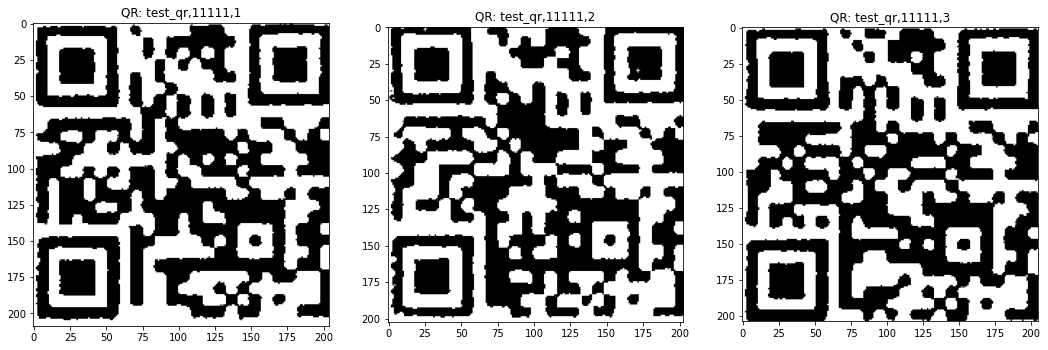

Looking for statement JSON file
Statement JSON file found
Looking for solution JSON file
Solution JSON file found
Extracting boxes with OpenCV
Analysing page 0
Preprocessing the page
Looking for the AMC circles


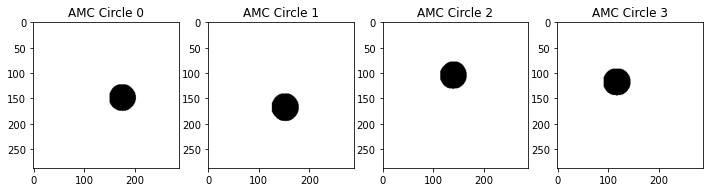

Looking for the expected checkboxes


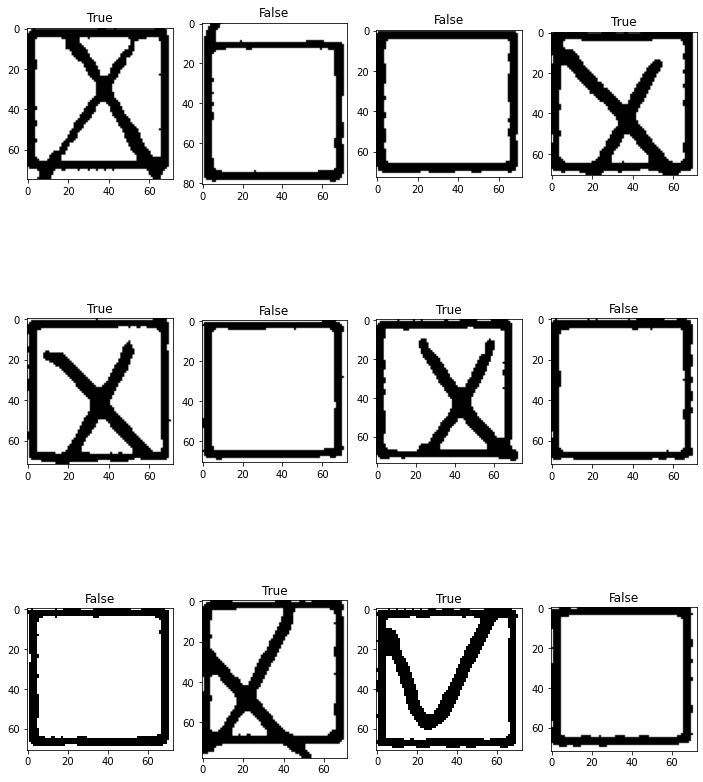

Analysing page 1
Preprocessing the page
Looking for the AMC circles


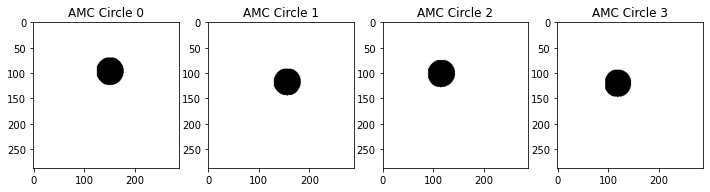

Looking for the expected checkboxes


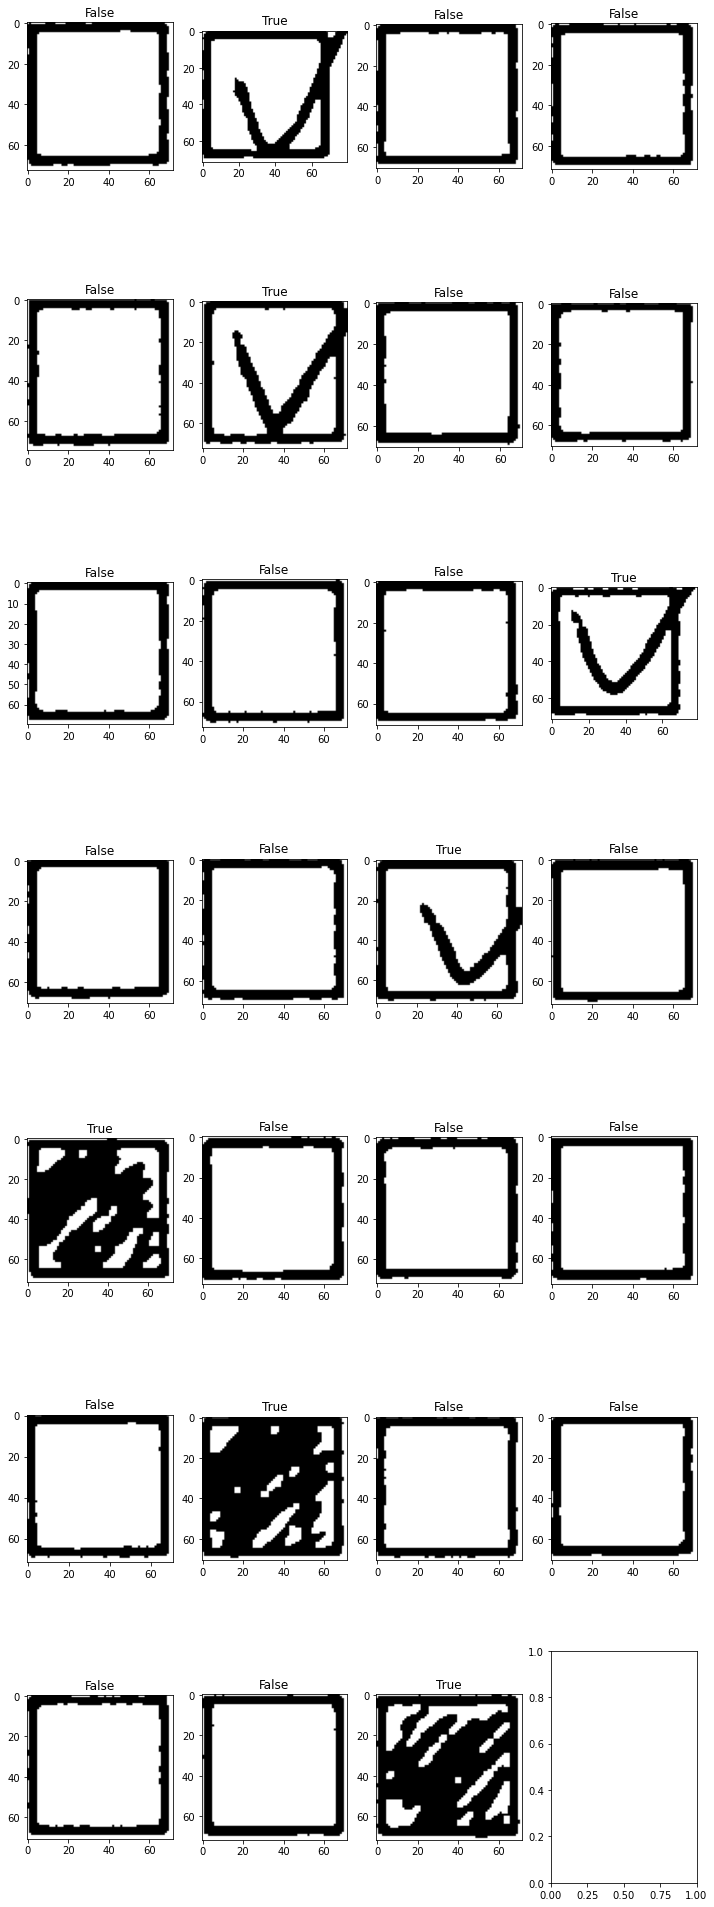

Analysing page 2
Preprocessing the page
Looking for the AMC circles


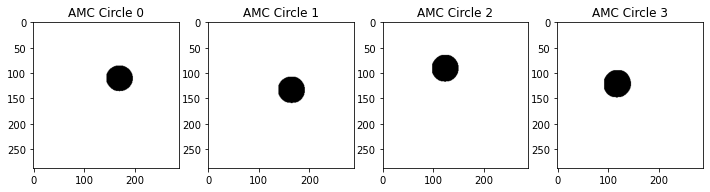

Looking for the expected checkboxes


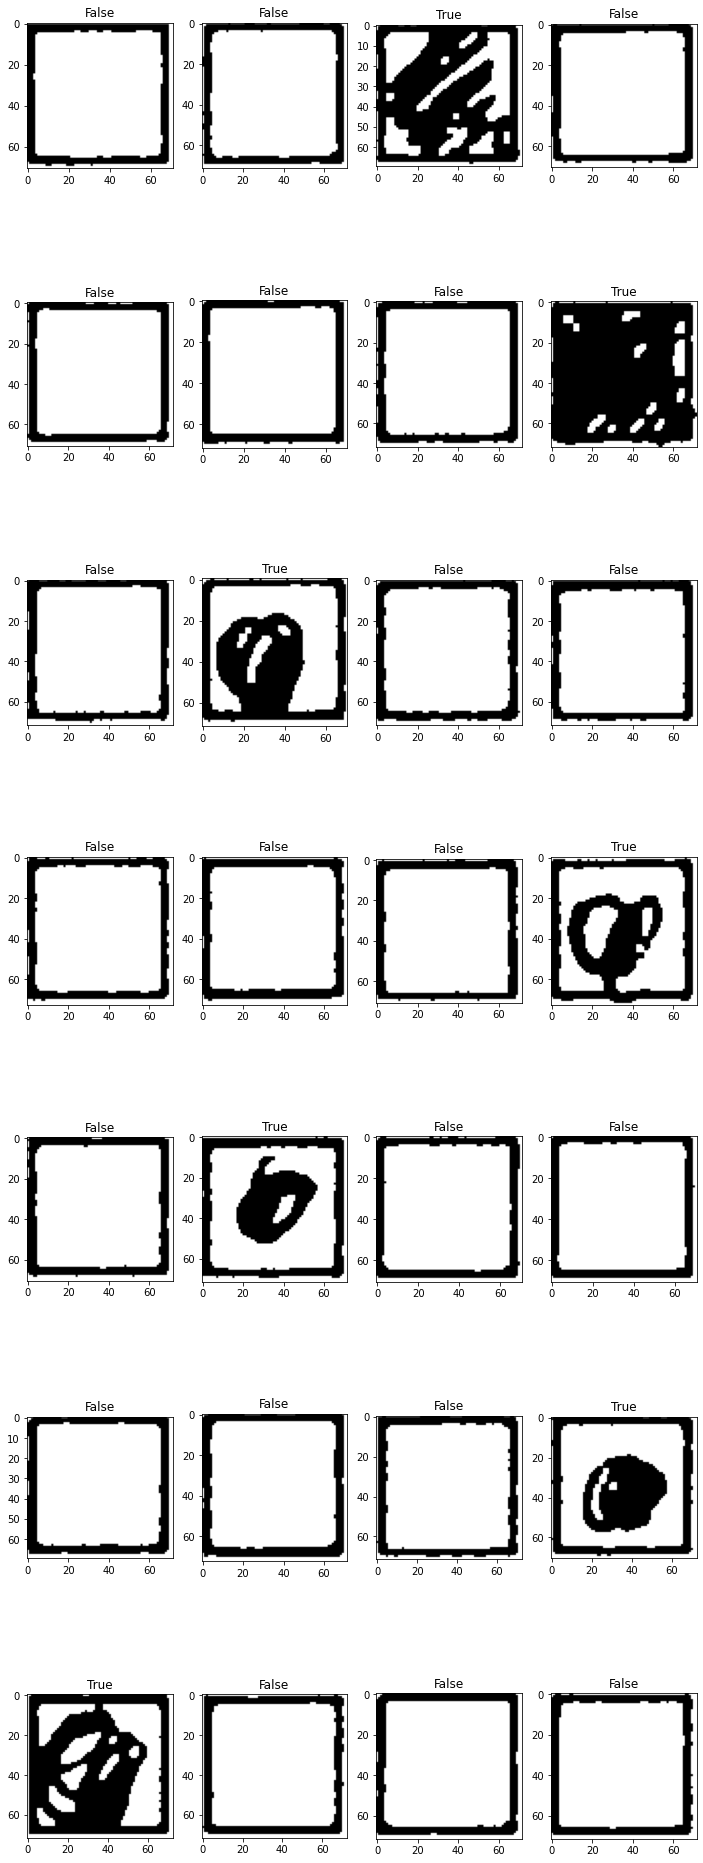

Grading the exam
Number of correct exercises: 9/20
Found file: /home/andres/Downloads/test casillas marcadas/scanned/do_folder/scanned_22222.pdf
Correcting file /home/andres/Downloads/test casillas marcadas/scanned/do_folder/scanned_22222.pdf
Looking for QR codes


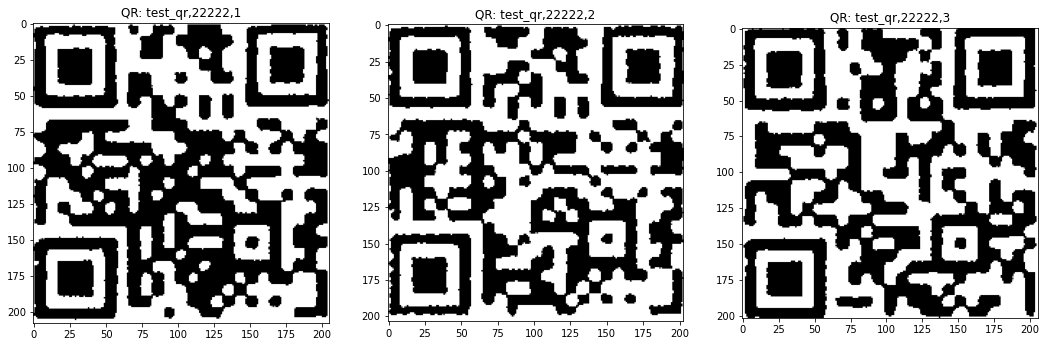

Looking for statement JSON file
Statement JSON file found
Looking for solution JSON file
Solution JSON file found
Extracting boxes with OpenCV
Analysing page 0
Preprocessing the page
Looking for the AMC circles


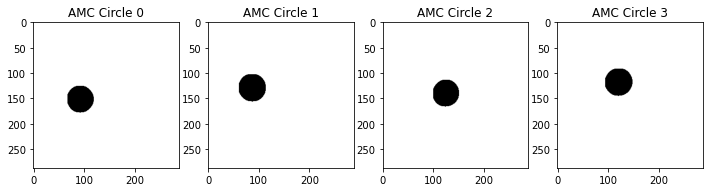

Looking for the expected checkboxes


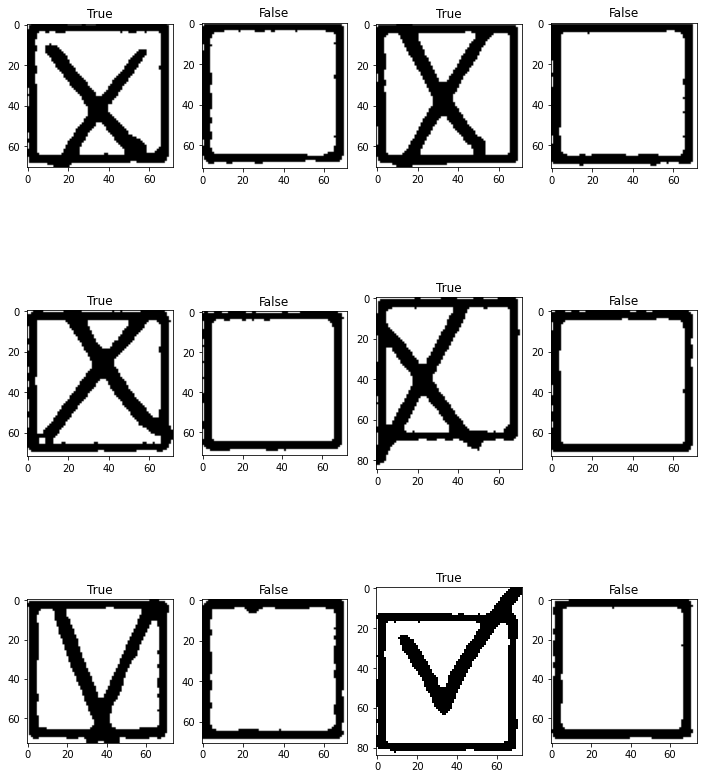

Analysing page 1
Preprocessing the page
Looking for the AMC circles


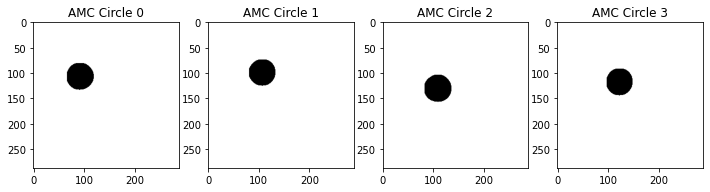

Looking for the expected checkboxes


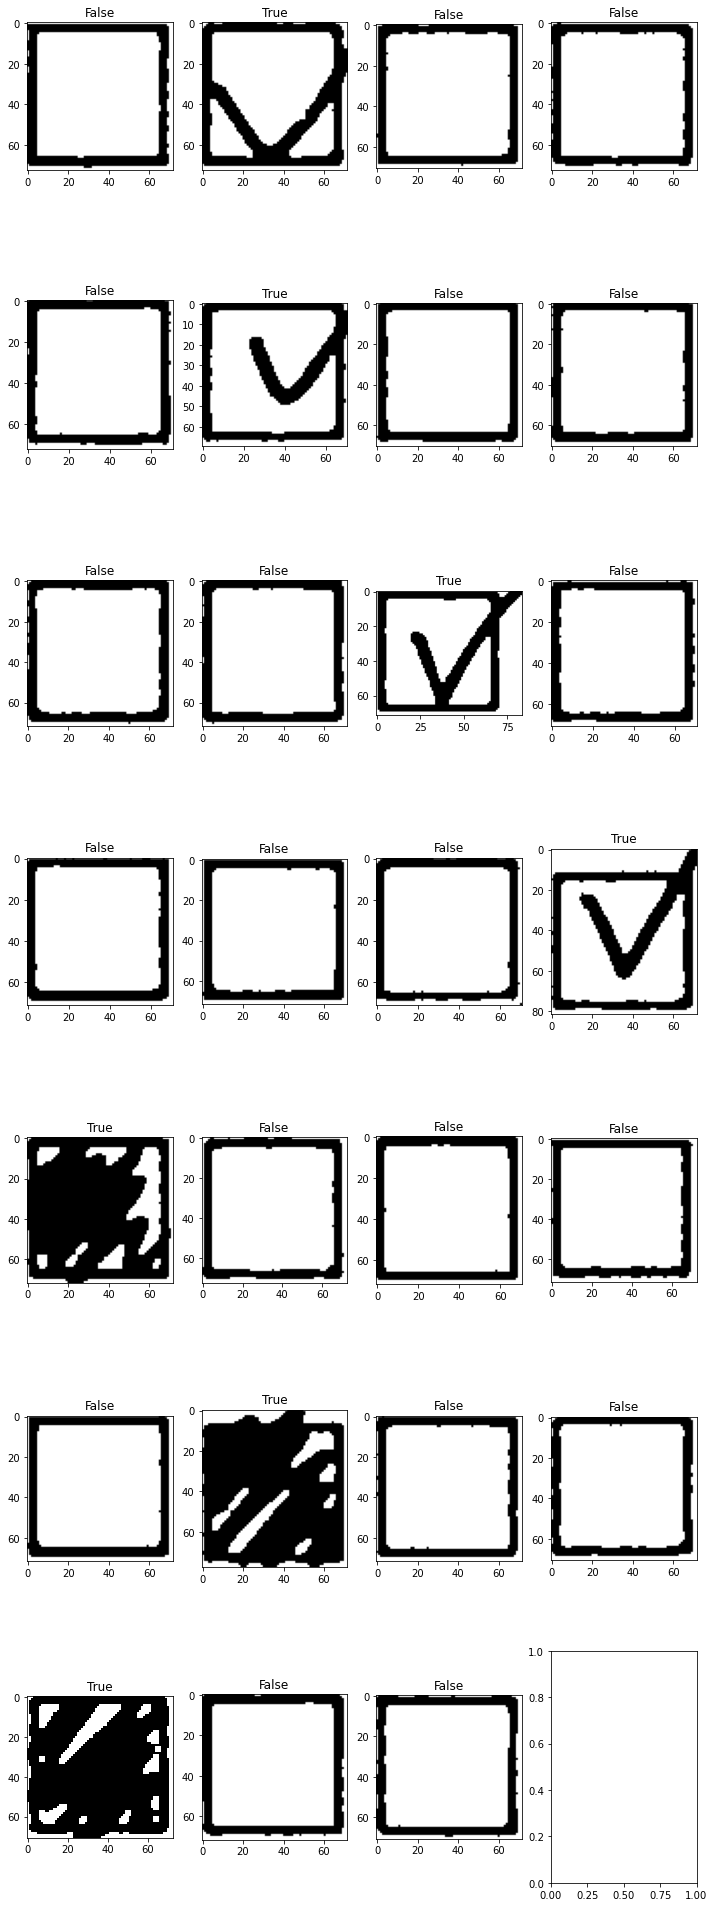

Analysing page 2
Preprocessing the page
Looking for the AMC circles


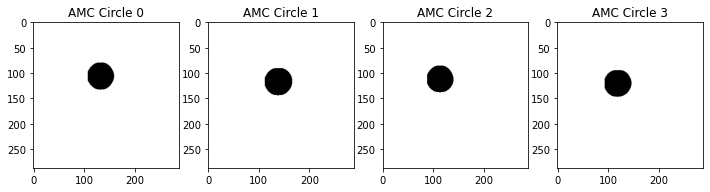

Looking for the expected checkboxes


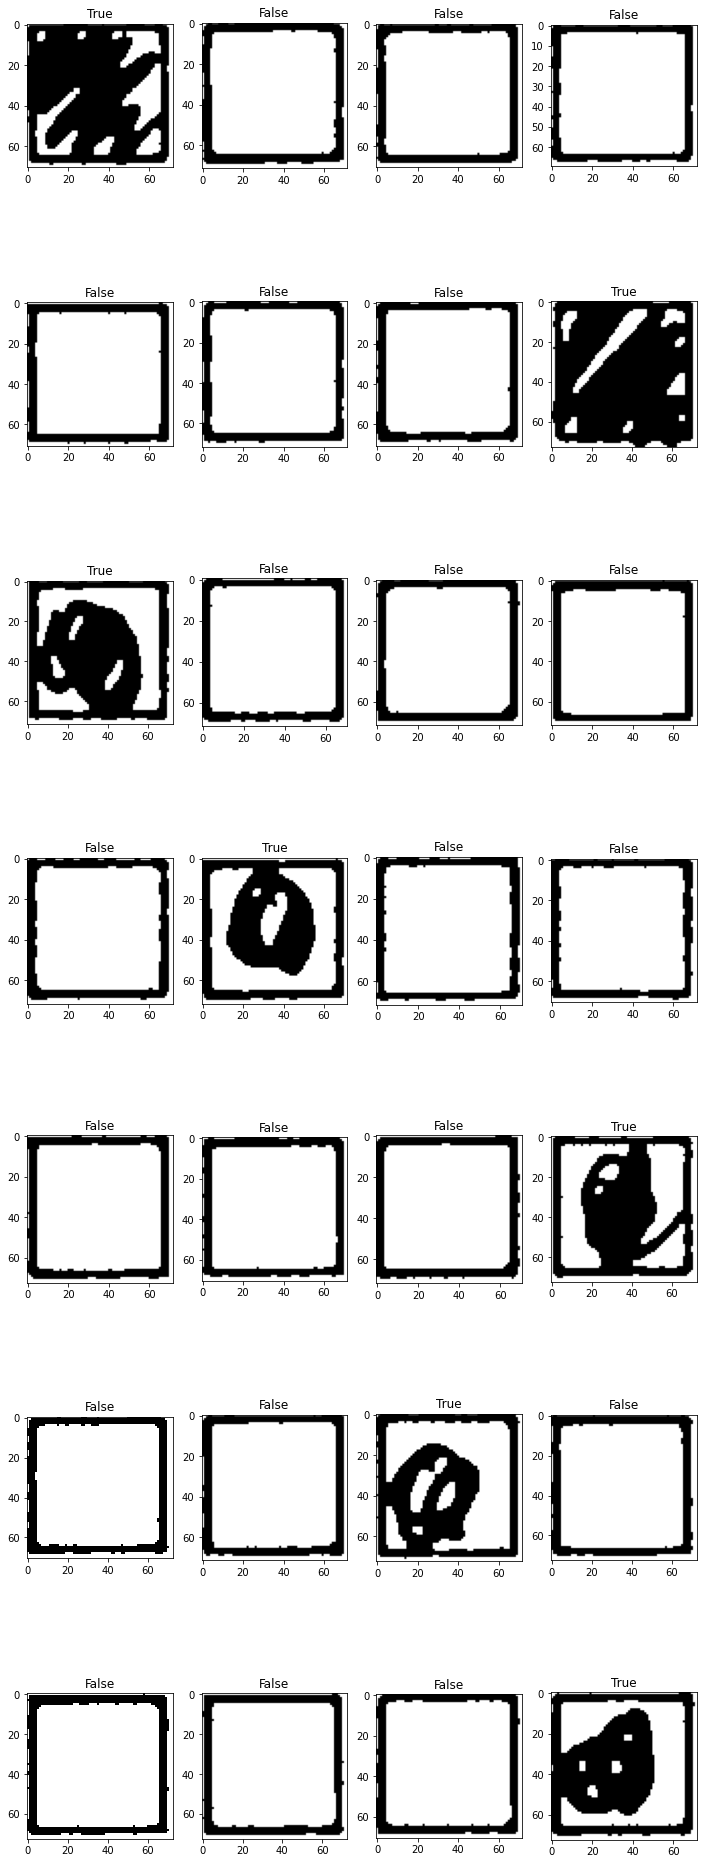

Grading the exam
Number of correct exercises: 8/20
Found file: /home/andres/Downloads/test casillas marcadas/scanned/do_folder/filled_44444.pdf
Correcting file /home/andres/Downloads/test casillas marcadas/scanned/do_folder/filled_44444.pdf
Looking for QR codes


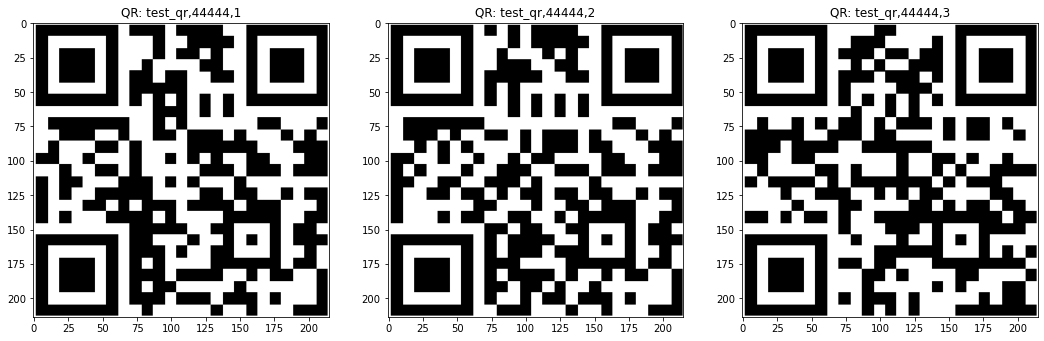

Looking for statement JSON file
Statement JSON file found
Looking for solution JSON file
Solution JSON file found
Extracting boxes with pyPDF2
Grading the exam
Number of correct exercises: 3/20
Found file: /home/andres/Downloads/test casillas marcadas/scanned/do_folder/filled_33333.pdf
Correcting file /home/andres/Downloads/test casillas marcadas/scanned/do_folder/filled_33333.pdf
Looking for QR codes


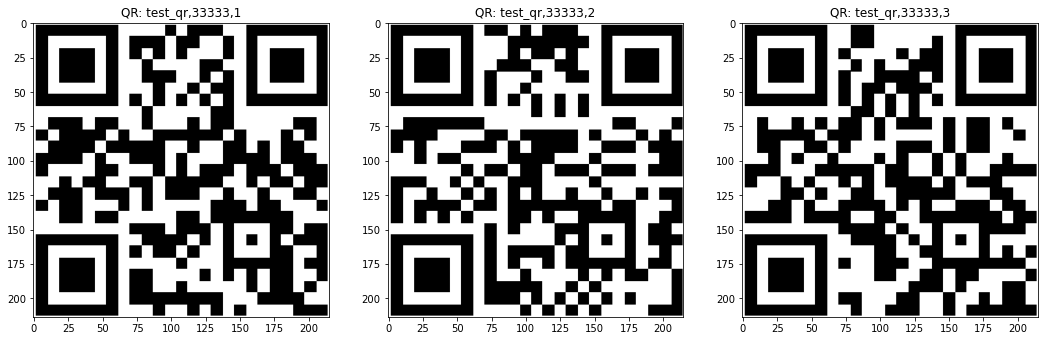

Looking for statement JSON file
Statement JSON file found
Looking for solution JSON file
Solution JSON file found
Extracting boxes with pyPDF2
Grading the exam
Number of correct exercises: 13/20


In [20]:
file = '/home/andres/Downloads/test casillas marcadas/scanned/do_folder'
analyse_dir(file, True)